In [1]:
!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [2]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

Text(0, 0.5, 'Values')

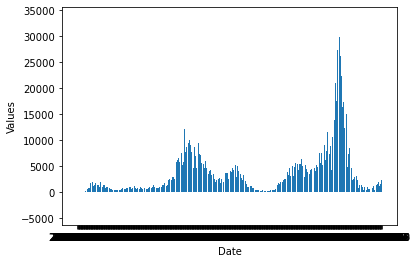

In [3]:
covid_df  = pd.read_csv('penn_uni.csv')
covid_df = covid_df.drop('PROVINCE_STATE_NAME', axis=1)

plt.bar(covid_df['Date'], covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])
plt.xlabel('Date')
plt.ylabel('Values')

<AxesSubplot:xlabel='PEOPLE_POSITIVE_NEW_CASES_COUNT', ylabel='Count'>

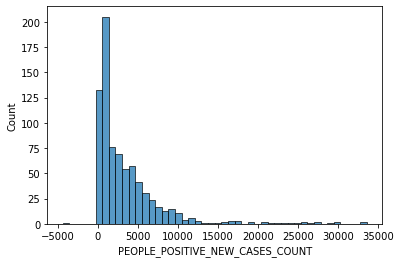

In [5]:
import seaborn as sns
sns.histplot(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])

Distribution is not normal, could be an opportunity for Linear Models.

In [6]:
covid_df  = covid_df.set_index('Date')
covid_df.index = pd.to_datetime(covid_df.index)
covid_df = covid_df.sort_index()
covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = np.clip(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], 0, None)

<AxesSubplot:xlabel='PEOPLE_POSITIVE_NEW_CASES_COUNT', ylabel='Count'>

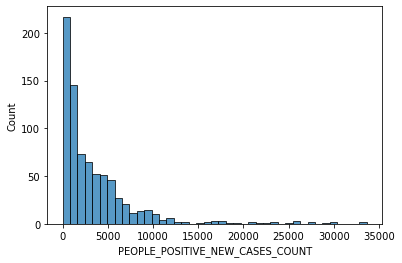

In [7]:
sns.histplot(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])

In [8]:
from statsmodels.tsa.stattools import adfuller
adfuller(covid_df)

(-2.519582888195778,
 0.11078200874892863,
 19,
 770,
 {'1%': -3.4388710830827125,
  '5%': -2.8653008652386576,
  '10%': -2.568772659807725},
 13299.193636659855)

Stationarity is not good, needs to be fixed. 

In [12]:
covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'].diff()
covid_df.fillna(0, inplace=True)

In [14]:
adfuller(covid_df)

(-10.053635093758057,
 1.391405349158161e-17,
 21,
 768,
 {'1%': -3.4388933482333464,
  '5%': -2.8653106782623574,
  '10%': -2.5687778874376086},
 13316.376477765105)

Stationarity is fixed

In [15]:
train_size = int(len(covid_df) * 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]

## Cross val

In [16]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size = 100, gap = 1)
covid_df = covid_df.sort_index()

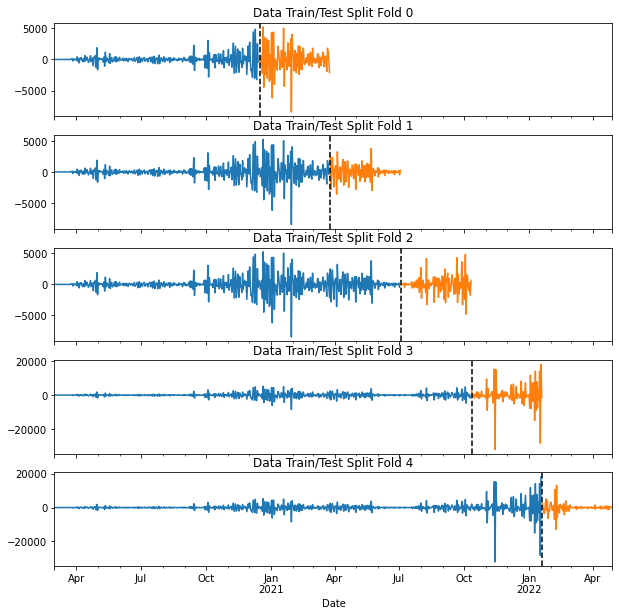

In [17]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(covid_df):
    train = covid_df.iloc[train_idx]
    test = covid_df.iloc[val_idx]
    train['PEOPLE_POSITIVE_NEW_CASES_COUNT'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## ACF & PACF

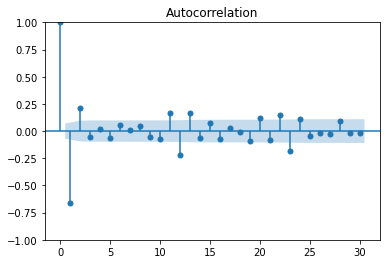

In [18]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], lags=30);

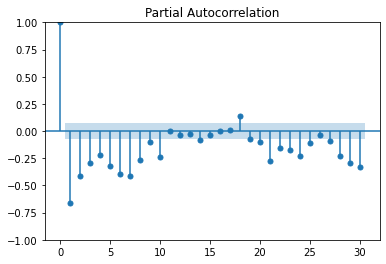

In [19]:
plot_pacf(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], lags=30);

## Baseline ARIMA

In [20]:
from statsmodels.tsa.arima.model import ARIMA
base_cali_arima = ARIMA(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'], order=(1, 0, 1))
base_cali_arima_fit = base_cali_arima.fit()

In [21]:
base_cali_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     PEOPLE_POSITIVE_NEW_CASES_COUNT   No. Observations:                  671
Model:                              ARIMA(1, 0, 1)   Log Likelihood               -5772.328
Date:                             Mon, 04 Mar 2024   AIC                          11552.656
Time:                                     23:17:46   BIC                          11570.691
Sample:                                 03-01-2020   HQIC                         11559.641
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1941      0.152      1.276      0.202      -0.104       0.492
ar.L1         -0.3007      0.009    -34.614      0.000      -0.318      -0.284
ma.L1         -1.0000      0.013    -75.980      0.000      -1.026      -0.974
sigma2      1.718e+06   7.68e-09   2.24e+14      0.000    1.72e+06    1.72e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.17   Jarque-Bera (JB):             48172.96
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):              50.70   Skew:                             1.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.88e+30. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date'>

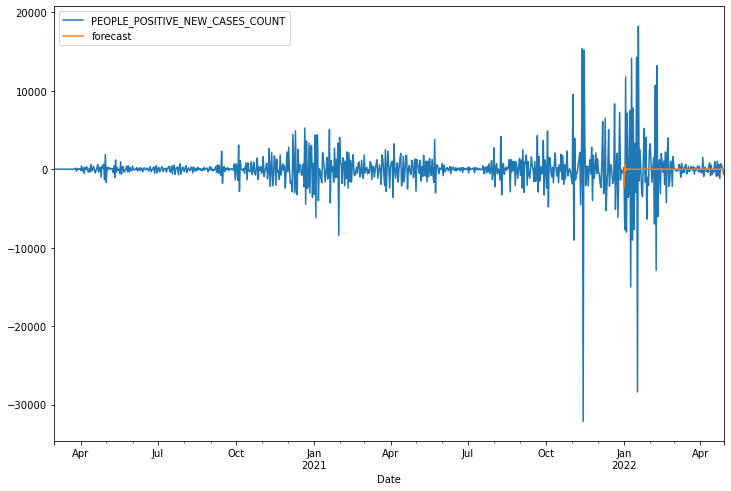

In [22]:
covid_df['forecast']= base_cali_arima_fit.forecast(steps = len(covid_test))
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

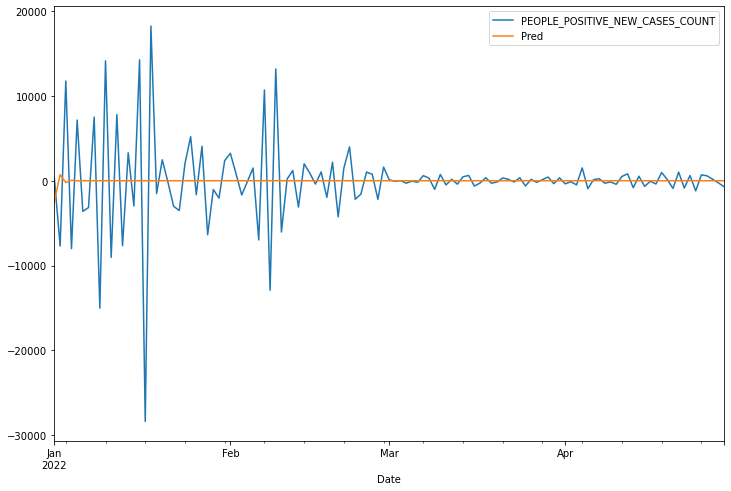

In [23]:
graph_df = pd.DataFrame(covid_test)
graph_df['Pred'] = base_cali_arima_fit.forecast(steps = len(covid_test))
graph_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','Pred']].plot(figsize=(12,8))

In [24]:
print('MAE = ', mean_absolute_error(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred']))
print('MASE = ', mase(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df['Pred'])))

MAE =  2731.4028176244215
MASE =  0.5400389942003887
RMSE =  5178.335943037817


## Tuned ARIMA

Going to try to do a Box Cox transformation to be used on linear models.

In [25]:
from scipy.stats import boxcox

covid_train_boxcox = pd.DataFrame(covid_train)
covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'].clip(lower=1)
to_transform = covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT'].values
transformed_data, lambda_value = boxcox(to_transform)
print("Lambda value:", lambda_value)
covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'] = transformed_data

Lambda value: -0.09515315780574105


<AxesSubplot:xlabel='PEOPLE_POSITIVE_NEW_CASES_COUNT_new', ylabel='Count'>

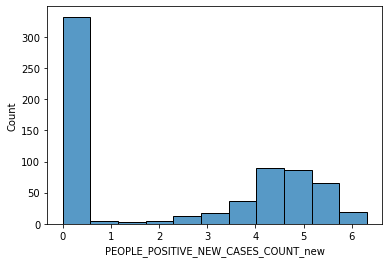

In [26]:
sns.histplot(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'])

New distribution here is much more normal than before, hopefully helps with improving the linear models. 

<BarContainer object of 671 artists>

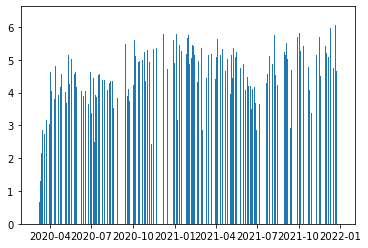

In [28]:
plt.bar(covid_train_boxcox.index, covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'])

In [29]:
# Grid Search

results=[]
for p in range(1,5):
    for q in range(1,5):
 #       cali_arima_gmodel=ARIMA(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q)).fit()
        cali_arima_gmodel=ARIMA(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(p,1,q)).fit()
        results.append([p,q,cali_arima_gmodel.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')


,p,q,aic
11,3,4,2887.917950
15,4,4,2888.299739
10,3,3,2892.802041
14,4,3,2894.311168
7,2,4,2897.384816
6,2,3,2922.185935
4,2,1,2940.349741
8,3,1,2942.084637
5,2,2,2942.177511
12,4,1,2943.124680


In [30]:
cali_after_gmodel=ARIMA(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(4,1,4))
cali_after_gmodel_fit =cali_after_gmodel.fit()

<AxesSubplot:xlabel='Date'>

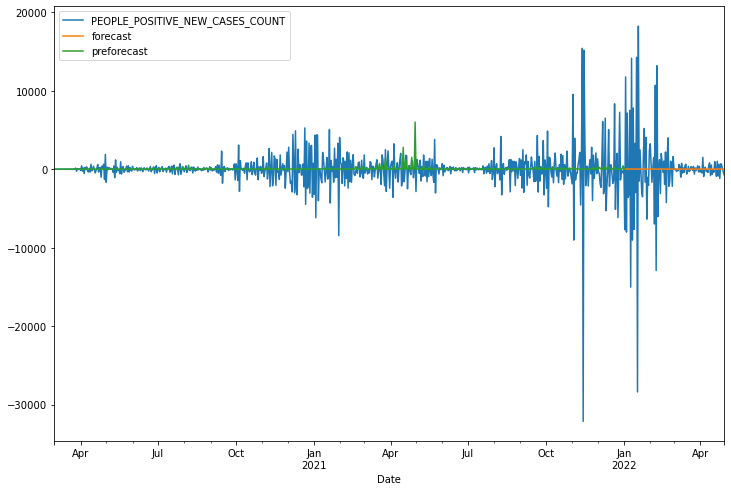

In [31]:
covid_df_predictions = pd.DataFrame(covid_df)

covid_df_predictions['forecast']= cali_after_gmodel_fit.forecast(steps = len(covid_test))
arima_back_transform_one = covid_df_predictions['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
covid_df_predictions['forecast'] = arima_back_transformed_one

covid_df_predictions['preforecast']= cali_after_gmodel_fit.predict(start = 0, end = 672)
arima_back_transform_two = covid_df_predictions['preforecast'].values
arima_back_transformed_two = np.power((arima_back_transform_two * lambda_value) + 1, 1 / lambda_value)
covid_df_predictions['preforecast'] = arima_back_transformed_two

covid_df_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

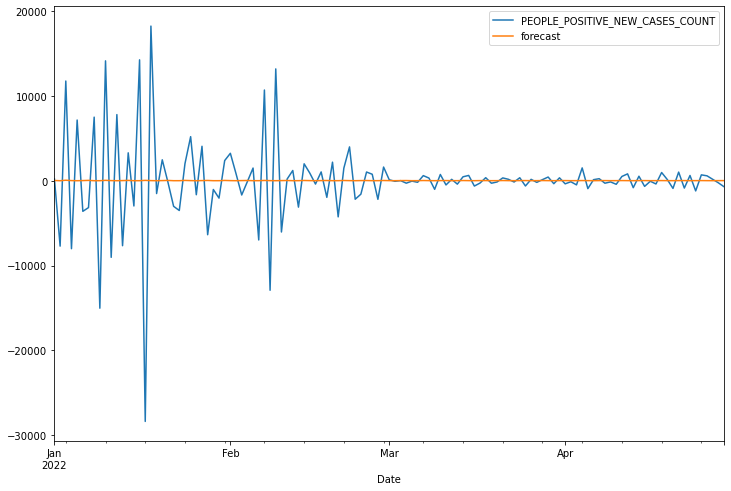

In [32]:
graph_df_1 = pd.DataFrame(covid_test)
graph_df_1['forecast']= cali_after_gmodel_fit.forecast(steps = len(covid_test))
arima_back_transform_one = graph_df_1['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_1['forecast'] = arima_back_transformed_one
graph_df_1[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [33]:
print('MAE = ', mean_absolute_error(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast']))
print('MASE = ', mase(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_1['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_1['forecast'])))

MAE =  2700.7654654817406
MASE =  0.5339815336422689
RMSE =  5157.677066413975


## Baseline SARIMA

In [34]:
import statsmodels.api as sm
baseline_sarima= sm.tsa.statespace.SARIMAX(covid_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results_sarima = baseline_sarima.fit()

<AxesSubplot:xlabel='Date'>

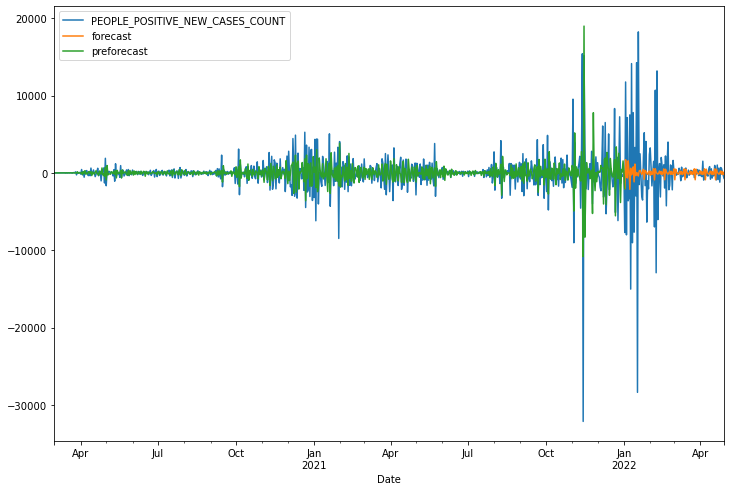

In [35]:
covid_df['forecast']= results_sarima.forecast(steps = len(covid_train))
covid_df['preforecast'] = results_sarima.predict(start = 0, end = 672)
covid_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

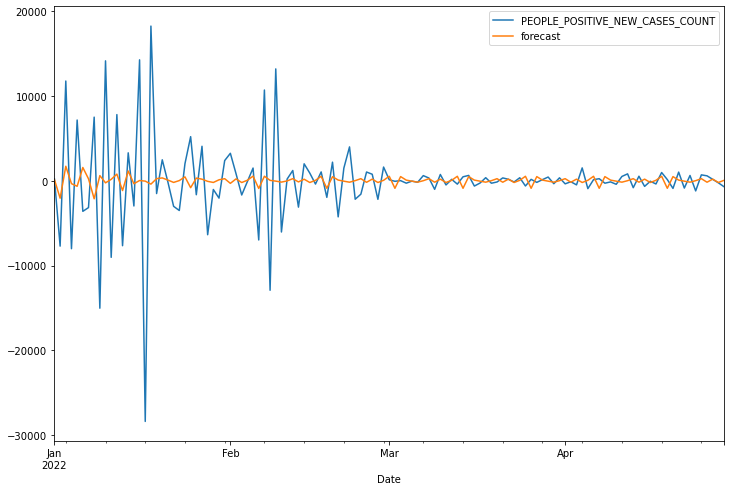

In [36]:
graph_df_3 = pd.DataFrame(covid_test)
graph_df_3['forecast']= results_sarima.forecast(steps = len(covid_test))
graph_df_3[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [37]:
print('MAE = ', mean_absolute_error(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast']))
print('MASE = ', mase(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_3['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_3['forecast'])))

MAE =  2714.34496511667
MASE =  0.5366664028520657
RMSE =  5143.6022856265035


## Tuned SARIMA

In [38]:

if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    # Beaware of the data input, use your training set
                    model=sm.tsa.statespace.SARIMAX(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])


1 1 1 1
1 1 1 2
1 1 2 1
1 1 2 2
1 2 1 1
1 2 1 2
1 2 2 1
1 2 2 2
2 1 1 1
2 1 1 2
2 1 2 1
2 1 2 2
2 2 1 1
2 2 1 2
2 2 2 1
2 2 2 2


In [39]:
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
df_results

,p,q,P,Q,aic
8,2,1,1,1,2939.593558
4,1,2,1,1,2941.269554
9,2,1,1,2,2941.519496
10,2,1,2,1,2941.529613
12,2,2,1,1,2941.550315
11,2,1,2,2,2942.973213
5,1,2,1,2,2943.263985
6,1,2,2,1,2943.265059
14,2,2,2,1,2943.493300
13,2,2,1,2,2943.510622


In [41]:
sarima = sm.tsa.statespace.SARIMAX(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results = sarima.fit()

<AxesSubplot:xlabel='Date'>

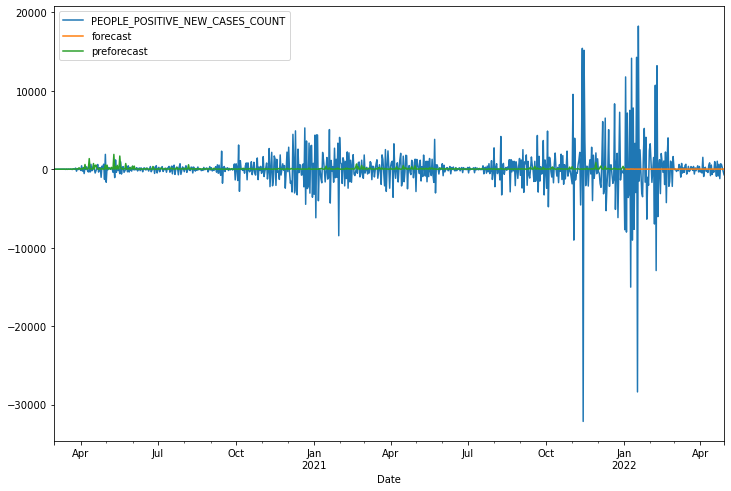

In [42]:
covid_df_sarima_predictions = pd.DataFrame(covid_df)

covid_df_sarima_predictions['forecast']=results.forecast(steps = len(covid_test))
sarima_back_transform_one = covid_df_sarima_predictions['forecast'].values
sarima_back_transformed_one = np.power((sarima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
covid_df_sarima_predictions['forecast'] = sarima_back_transformed_one

covid_df_sarima_predictions['preforecast'] = results.predict(start = 0, end = 672)
sarima_back_transform_two = covid_df_sarima_predictions['preforecast'].values
sarima_back_transformed_two = np.power((sarima_back_transform_two * lambda_value) + 1, 1 / lambda_value)
covid_df_sarima_predictions['preforecast'] = sarima_back_transformed_two

covid_df_sarima_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

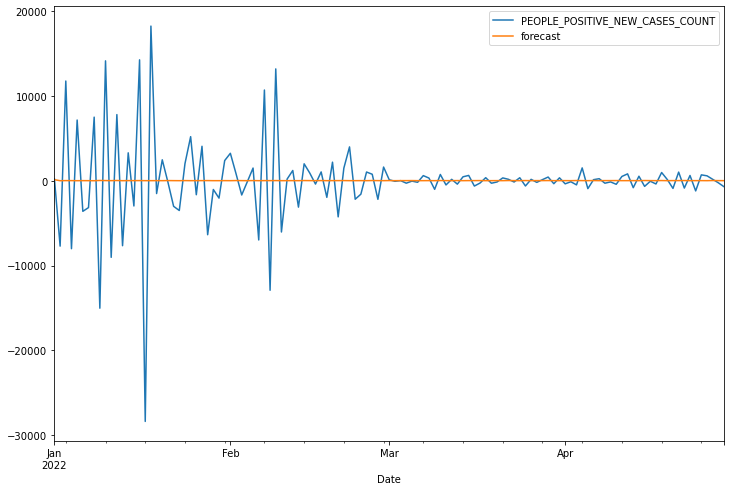

In [43]:
graph_df_4 = pd.DataFrame(covid_test)
graph_df_4['forecast']= results.forecast(steps = len(covid_test))
arima_back_transform_one = graph_df_4['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_4['forecast'] = arima_back_transformed_one
graph_df_4[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [44]:
print('MAE = ', mean_absolute_error(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast']))
print('MASE = ', mase(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_4['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_4['forecast'])))

MAE =  2701.6980292427693
MASE =  0.5341659153791133
RMSE =  5157.977836180959


## Auto-ARIMA

In [45]:
from pmdarima import auto_arima

In [46]:
auto_model = auto_arima(covid_train_boxcox['PEOPLE_POSITIVE_NEW_CASES_COUNT_new'], seasonal=True, trace=True, suppress_warnings=True, stepwise=True, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2943.463, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3724.762, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3376.731, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3722.762, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2945.990, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2941.686, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3175.936, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2943.313, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3091.156, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2945.683, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2940.350, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2958.498, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3

2940.349740633784


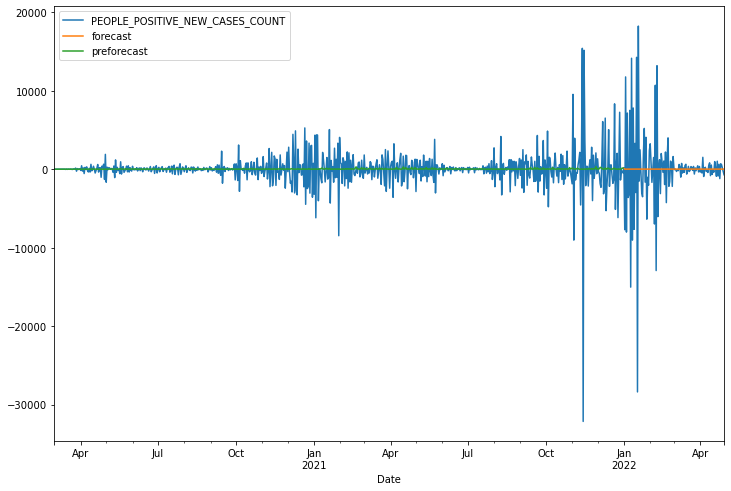

In [47]:
covid_auto_predictions = pd.DataFrame(covid_df)

auto_predictions = auto_model.predict(n_periods=len(covid_test))
auto_predictions = np.power((auto_predictions * lambda_value) + 1, 1 / lambda_value)
covid_auto_predictions['forecast'] = auto_predictions

auto_predict_before = auto_model.fittedvalues()
auto_predict_before = np.power((auto_predict_before * lambda_value) + 1, 1 / lambda_value)
covid_auto_predictions['preforecast'] = auto_predict_before

covid_auto_predictions[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast', 'preforecast']].plot(figsize=(12,8))
print(auto_model.aic())

<AxesSubplot:xlabel='Date'>

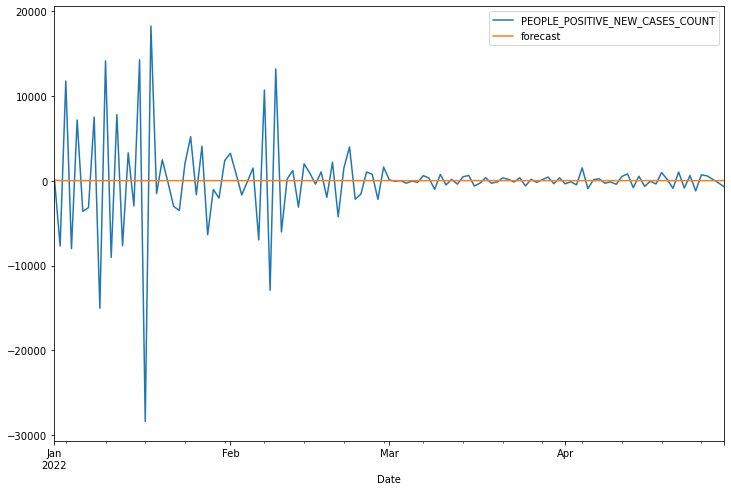

In [48]:
graph_df_5 = pd.DataFrame(covid_test)
graph_df_5['forecast']= auto_model.predict(n_periods=len(covid_test))
arima_back_transform_one = graph_df_5['forecast'].values
arima_back_transformed_one = np.power((arima_back_transform_one * lambda_value) + 1, 1 / lambda_value)
graph_df_5['forecast'] = arima_back_transformed_one
graph_df_5[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [49]:
print('MAE = ', mean_absolute_error(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast']))
print('MASE = ', mase(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast']))
print('RMSE = ', np.sqrt(mean_squared_error(graph_df_5['PEOPLE_POSITIVE_NEW_CASES_COUNT'], graph_df_5['forecast'])))

MAE =  2702.131767701213
MASE =  0.5342516719285799
RMSE =  5158.333381353839
